In [5]:
import sys
sys.path.append('../')

from generate_bf import *
from computesk import *
import numpy as np
import torch

import numpy as np
import copy
import torch
import torch.optim as optim
import os

from models.UMNN import MonotonicNN
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
num_test = 10000
num_pairs = 5
num_features = num_pairs * 2
hidden_layers = [64, 64, 64]
nb_steps = 50

lr = 0.01
num_epochs = 100

In [3]:
testing_samples_path = 'BF/BF-samples/bf-testing_samples5p.txt'
validation_samples_path = 'BF/BF-samples/bf-validation_samples5p.txt'
save_path = 'BF/BF-saved_models/BF-10p-64_64_64.es_samples' # Change this!

In [4]:
# testing_samples = generate_easy_bf(num_test, num_pairs)
# validation_samples = generate_easy_bf(num_test, num_pairs)

# np.savetxt(testing_samples_path, testing_samples)
# np.savetxt(validation_samples_path, validation_samples)

In [5]:
test_samples = torch.tensor(np.loadtxt(testing_samples_path)).to(torch.float32)
validation_samples = torch.tensor(np.loadtxt(validation_samples_path)).to(torch.float32)

print(test_samples)

tensor([[ 0.8289,  1.3503,  0.3256,  ...,  0.1962, -0.2516, -0.4202],
        [-0.0587,  0.0026, -0.6916,  ..., -0.1389,  0.4334, -0.5928],
        [ 0.5460,  0.4231, -0.8863,  ...,  0.5025,  0.9002, -0.2475],
        ...,
        [ 0.3147,  0.5331,  1.0124,  ...,  0.5237,  0.6708,  0.3994],
        [-0.4309,  1.3082, -1.1901,  ...,  0.2698, -0.3909,  0.1544],
        [ 1.2388,  0.5343, -0.1850,  ...,  2.4728, -0.6737,  1.1008]])


In [6]:
test_samples.shape

torch.Size([10000, 10])

In [7]:
training_sizes = [10000]
random_regs = [0.1, 0.01, 0.001, 0]

In [8]:
kths = list(range(num_features))
fixed_map = generate_non_linear_maps(num_features, hidden_layers, nb_steps, 'cpu')

In [9]:
opt_regs = {}
all_test_losses = {}
all_learnt_maps = {}
all_opt_maps = {}
test_no_reg_losses = {}

# Learn Sk map

In [10]:

for t in range(len(training_sizes)):
    num_train = training_sizes[t]
    X_tr = generate_easy_bf(num_train, num_pairs)

    for i in kths:

        kth = i
        print('kth =', kth)
        best_val_overall = float('inf')
        opt_reg = 0
        opt_Sk = None # should this be moved in?
        each_learnt_map = {}
        non_kth = [idx for idx in range(X_tr.shape[1]) if idx != kth]

        for j in tqdm(range(len(random_regs)), desc='Random Regs', leave=False):
            regLambda = random_regs[j]
            Sk = copy.deepcopy(fixed_map)[kth]
            optimizer = optim.Adam(Sk.parameters(), lr=lr)
            n = X_tr.shape[0]
            early_stop_counter = 0
            best_epoch = 0
            best_valL = float('inf')
            for epoch in range(num_epochs):
                zk = X_tr.detach().requires_grad_(True)
                h = zk[:, non_kth]
                x = zk[:, [kth]]
               
                sk_zi = Sk(x, h)
                jacobian = torch.autograd.grad(sk_zi, x, torch.ones_like(sk_zi), create_graph=True)[0]
                # L = 1/2 Sk^2 - log \partial_k Sk (z_i)
                loss = (0.5 * sk_zi**2 - torch.log(jacobian)).sum(axis=0) / n #mapS_losses(sk_zi, jacobian).sum(axis=0) / n#, kth)
                
                # With regularized loss
                regulariser = torch.sqrt((jacobian**2).sum(axis=0) / n)
                loss += regLambda * regulariser
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Validation
                Sk_zi_val, jacobian_val = test_map(validation_samples, non_kth, kth, Sk)
                val_loss = test_losses(Sk_zi_val, jacobian_val)#, kth)
                print(f'Val {num_train}st λ = {regLambda}, Epoch {epoch}: {val_loss}')

                # Save the smallest validation loss at each loop.
                if val_loss[1] < best_valL:
                    best_valL = val_loss[1]
                    if val_loss[1] < best_val_overall: # overall for all λ and epoch
                        best_val_overall = val_loss[1]
                        opt_reg = regLambda
                        opt_Sk = Sk
                        
                    best_epoch = epoch
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

                # Check for early stopping
                if early_stop_counter >= 10:
                    print(f'Early stopping at Epoch {epoch} for best epoch {best_epoch}.')
                    break

            each_learnt_map.setdefault(regLambda, []).append(Sk)

        # Test the best model
        Sk_zi_test, jacobian_test = test_map(test_samples, non_kth, kth, opt_Sk)

        all_test_losses.setdefault(num_train, []).append(test_losses(Sk_zi_test, jacobian_test))###, kth))
        print(f'Test {num_train}, λ = {opt_reg}: {all_test_losses[num_train]}')

        all_learnt_maps.setdefault(num_train, []).append(each_learnt_map)
        all_opt_maps.setdefault(num_train, []).append(opt_Sk)
        opt_regs.setdefault(num_train, []).append(opt_reg)
        
    print('Optimal λ ∀ =', opt_regs)


kth = 0


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (0.30021172761917114, 1.664057970046997)
Val 10000st λ = 0.1, Epoch 1: (0.507659912109375, 1.4192912578582764)
Val 10000st λ = 0.1, Epoch 2: (0.8193294405937195, 1.409524917602539)
Val 10000st λ = 0.1, Epoch 3: (0.8300850987434387, 1.4106712341308594)
Val 10000st λ = 0.1, Epoch 4: (0.7500258684158325, 1.4021105766296387)
Val 10000st λ = 0.1, Epoch 5: (0.6732593774795532, 1.3994169235229492)
Val 10000st λ = 0.1, Epoch 6: (0.6086910367012024, 1.4001882076263428)
Val 10000st λ = 0.1, Epoch 7: (0.5606253147125244, 1.4013350009918213)
Val 10000st λ = 0.1, Epoch 8: (0.5342411398887634, 1.399636149406433)
Val 10000st λ = 0.1, Epoch 9: (0.5273399353027344, 1.3936569690704346)
Val 10000st λ = 0.1, Epoch 10: (0.5346090197563171, 1.3841708898544312)
Val 10000st λ = 0.1, Epoch 11: (0.5507991313934326, 1.3729627132415771)
Val 10000st λ = 0.1, Epoch 12: (0.5709286332130432, 1.3617229461669922)
Val 10000st λ = 0.1, Epoch 13: (0.5908961892127991, 1.3513963222503662)
Val 1

Random Regs:  25%|██▌       | 1/4 [08:25<25:17, 505.72s/it]

Val 10000st λ = 0.1, Epoch 99: (1.0001964569091797, 1.1460309028625488)
Val 10000st λ = 0.01, Epoch 0: (0.37886232137680054, 1.5044854879379272)
Val 10000st λ = 0.01, Epoch 1: (0.8059189915657043, 1.4008952379226685)
Val 10000st λ = 0.01, Epoch 2: (0.8937255144119263, 1.4101083278656006)
Val 10000st λ = 0.01, Epoch 3: (0.7699035406112671, 1.3873646259307861)
Val 10000st λ = 0.01, Epoch 4: (0.6621561646461487, 1.3772996664047241)
Val 10000st λ = 0.01, Epoch 5: (0.5954012274742126, 1.3751060962677002)
Val 10000st λ = 0.01, Epoch 6: (0.565416157245636, 1.3712577819824219)
Val 10000st λ = 0.01, Epoch 7: (0.5677112936973572, 1.3609567880630493)
Val 10000st λ = 0.01, Epoch 8: (0.5961486101150513, 1.3462902307510376)
Val 10000st λ = 0.01, Epoch 9: (0.643939733505249, 1.3328746557235718)
Val 10000st λ = 0.01, Epoch 10: (0.7034228444099426, 1.3239542245864868)
Val 10000st λ = 0.01, Epoch 11: (0.7636578679084778, 1.3193894624710083)
Val 10000st λ = 0.01, Epoch 12: (0.8036687970161438, 1.31693542

Random Regs:  50%|█████     | 2/4 [18:45<19:05, 572.94s/it]

Val 10000st λ = 0.01, Epoch 75: (1.3991341590881348, 1.1413518190383911)
Early stopping at Epoch 75 for best epoch 65.
Val 10000st λ = 0.001, Epoch 0: (0.39206668734550476, 1.490267276763916)
Val 10000st λ = 0.001, Epoch 1: (0.8481682538986206, 1.405853271484375)
Val 10000st λ = 0.001, Epoch 2: (0.8815637230873108, 1.406687617301941)
Val 10000st λ = 0.001, Epoch 3: (0.7514730095863342, 1.3838855028152466)
Val 10000st λ = 0.001, Epoch 4: (0.6486808657646179, 1.3751354217529297)
Val 10000st λ = 0.001, Epoch 5: (0.5875943899154663, 1.3730864524841309)
Val 10000st λ = 0.001, Epoch 6: (0.5649210214614868, 1.3680906295776367)
Val 10000st λ = 0.001, Epoch 7: (0.5748944282531738, 1.3564505577087402)
Val 10000st λ = 0.001, Epoch 8: (0.6117460131645203, 1.3415888547897339)
Val 10000st λ = 0.001, Epoch 9: (0.6689615845680237, 1.3294631242752075)
Val 10000st λ = 0.001, Epoch 10: (0.7370182275772095, 1.322669267654419)
Val 10000st λ = 0.001, Epoch 11: (0.7981330752372742, 1.3199535608291626)
Val 10

Random Regs:  75%|███████▌  | 3/4 [28:10<09:29, 569.01s/it]

Val 10000st λ = 0.001, Epoch 70: (1.9808887243270874, 1.1899675130844116)
Early stopping at Epoch 70 for best epoch 60.
Val 10000st λ = 0, Epoch 0: (0.39434611797332764, 1.488022804260254)
Val 10000st λ = 0, Epoch 1: (0.8603798747062683, 1.4075275659561157)
Val 10000st λ = 0, Epoch 2: (0.8782187700271606, 1.4056447744369507)
Val 10000st λ = 0, Epoch 3: (0.7454224824905396, 1.3828154802322388)
Val 10000st λ = 0, Epoch 4: (0.6436648964881897, 1.3747203350067139)
Val 10000st λ = 0, Epoch 5: (0.5848991274833679, 1.372915267944336)
Val 10000st λ = 0, Epoch 6: (0.5651293396949768, 1.367499828338623)
Val 10000st λ = 0, Epoch 7: (0.5777968168258667, 1.3553862571716309)
Val 10000st λ = 0, Epoch 8: (0.6167515516281128, 1.340563416481018)
Val 10000st λ = 0, Epoch 9: (0.6755756139755249, 1.3288331031799316)
Val 10000st λ = 0, Epoch 10: (0.7440292835235596, 1.3224209547042847)
Val 10000st λ = 0, Epoch 11: (0.8023879528045654, 1.3197646141052246)
Val 10000st λ = 0, Epoch 12: (0.8248503804206848, 1.3

Val 10000st λ = 0, Epoch 69: (2.3847403526306152, 1.2147737741470337)
Early stopping at Epoch 69 for best epoch 59.


Test 10000, λ = 0.01: [(1.1730848550796509, 1.1236642599105835)]
kth = 1


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (1.3862791061401367, 1.3948642015457153)
Val 10000st λ = 0.1, Epoch 1: (0.7017661333084106, 1.433489203453064)
Val 10000st λ = 0.1, Epoch 2: (0.955545961856842, 1.331644058227539)
Val 10000st λ = 0.1, Epoch 3: (1.2175688743591309, 1.2895394563674927)
Val 10000st λ = 0.1, Epoch 4: (0.9499921798706055, 1.2401151657104492)
Val 10000st λ = 0.1, Epoch 5: (0.759518563747406, 1.2057832479476929)
Val 10000st λ = 0.1, Epoch 6: (0.8609800338745117, 1.1491317749023438)
Val 10000st λ = 0.1, Epoch 7: (1.144119381904602, 1.1112873554229736)
Val 10000st λ = 0.1, Epoch 8: (0.8919388055801392, 1.0876452922821045)
Val 10000st λ = 0.1, Epoch 9: (0.9806300401687622, 1.080191969871521)
Val 10000st λ = 0.1, Epoch 10: (1.1395362615585327, 1.0380624532699585)
Val 10000st λ = 0.1, Epoch 11: (1.0052926540374756, 1.0368456840515137)
Val 10000st λ = 0.1, Epoch 12: (0.9659098982810974, 1.0281791687011719)
Val 10000st λ = 0.1, Epoch 13: (1.0388314723968506, 1.0005604028701782)
Val 1000

Random Regs:  25%|██▌       | 1/4 [05:15<15:45, 315.29s/it]

Val 10000st λ = 0.1, Epoch 41: (1.0642726421356201, 0.924279510974884)
Early stopping at Epoch 41 for best epoch 31.
Val 10000st λ = 0.01, Epoch 0: (1.8830032348632812, 1.4351590871810913)
Val 10000st λ = 0.01, Epoch 1: (0.8984538912773132, 1.411313533782959)
Val 10000st λ = 0.01, Epoch 2: (0.8410265445709229, 1.3813581466674805)
Val 10000st λ = 0.01, Epoch 3: (0.916425883769989, 1.3359005451202393)
Val 10000st λ = 0.01, Epoch 4: (0.9550283551216125, 1.2965909242630005)
Val 10000st λ = 0.01, Epoch 5: (0.9113324284553528, 1.2526620626449585)
Val 10000st λ = 0.01, Epoch 6: (0.826772928237915, 1.2052994966506958)
Val 10000st λ = 0.01, Epoch 7: (0.8199161291122437, 1.1607131958007812)
Val 10000st λ = 0.01, Epoch 8: (0.971852719783783, 1.1185868978500366)
Val 10000st λ = 0.01, Epoch 9: (1.1429834365844727, 1.0922515392303467)
Val 10000st λ = 0.01, Epoch 10: (1.0803918838500977, 1.080671787261963)
Val 10000st λ = 0.01, Epoch 11: (1.4697870016098022, 1.0790143013000488)
Val 10000st λ = 0.01, 

Random Regs:  50%|█████     | 2/4 [11:31<11:41, 350.83s/it]

Val 10000st λ = 0.01, Epoch 49: (1.1979374885559082, 0.8595946431159973)
Early stopping at Epoch 49 for best epoch 39.
Val 10000st λ = 0.001, Epoch 0: (1.9300669431686401, 1.4405851364135742)
Val 10000st λ = 0.001, Epoch 1: (0.9280270338058472, 1.4096356630325317)
Val 10000st λ = 0.001, Epoch 2: (0.8503807783126831, 1.3828810453414917)
Val 10000st λ = 0.001, Epoch 3: (0.9137763977050781, 1.3384294509887695)
Val 10000st λ = 0.001, Epoch 4: (0.9497206807136536, 1.29914391040802)
Val 10000st λ = 0.001, Epoch 5: (0.9096705317497253, 1.2557059526443481)
Val 10000st λ = 0.001, Epoch 6: (0.8298888206481934, 1.2084343433380127)
Val 10000st λ = 0.001, Epoch 7: (0.8181803226470947, 1.1640578508377075)
Val 10000st λ = 0.001, Epoch 8: (0.9588434100151062, 1.1224887371063232)
Val 10000st λ = 0.001, Epoch 9: (1.1498781442642212, 1.0976121425628662)
Val 10000st λ = 0.001, Epoch 10: (1.0957800149917603, 1.0818572044372559)
Val 10000st λ = 0.001, Epoch 11: (1.431279182434082, 1.0751502513885498)
Val 10

Random Regs:  75%|███████▌  | 3/4 [20:09<07:07, 427.44s/it]

Val 10000st λ = 0.001, Epoch 68: (1.3942419290542603, 0.852211058139801)
Early stopping at Epoch 68 for best epoch 58.
Val 10000st λ = 0, Epoch 0: (1.9445812702178955, 1.442278265953064)
Val 10000st λ = 0, Epoch 1: (0.9368908405303955, 1.4086732864379883)
Val 10000st λ = 0, Epoch 2: (0.8480302691459656, 1.3835442066192627)
Val 10000st λ = 0, Epoch 3: (0.9080663919448853, 1.3394817113876343)
Val 10000st λ = 0, Epoch 4: (0.9460576772689819, 1.300437569618225)
Val 10000st λ = 0, Epoch 5: (0.9097096920013428, 1.2576022148132324)
Val 10000st λ = 0, Epoch 6: (0.8307539820671082, 1.2108734846115112)
Val 10000st λ = 0, Epoch 7: (0.8134499788284302, 1.1672451496124268)
Val 10000st λ = 0, Epoch 8: (0.9429656267166138, 1.1252577304840088)
Val 10000st λ = 0, Epoch 9: (1.1424742937088013, 1.100032925605774)
Val 10000st λ = 0, Epoch 10: (1.102006435394287, 1.0816130638122559)
Val 10000st λ = 0, Epoch 11: (1.3857879638671875, 1.0715419054031372)
Val 10000st λ = 0, Epoch 12: (1.1056629419326782, 1.041

Val 10000st λ = 0, Epoch 60: (1.3033053874969482, 0.8415172100067139)
Early stopping at Epoch 60 for best epoch 50.


Test 10000, λ = 0: [(1.1730848550796509, 1.1236642599105835), (1.3321253061294556, 0.8479856252670288)]
kth = 2


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (1.448615550994873, 1.549540638923645)
Val 10000st λ = 0.1, Epoch 1: (0.5334495306015015, 1.396978497505188)
Val 10000st λ = 0.1, Epoch 2: (0.37109994888305664, 1.458501935005188)
Val 10000st λ = 0.1, Epoch 3: (0.38993993401527405, 1.4392235279083252)
Val 10000st λ = 0.1, Epoch 4: (0.44597873091697693, 1.409683346748352)
Val 10000st λ = 0.1, Epoch 5: (0.5018667578697205, 1.3926867246627808)
Val 10000st λ = 0.1, Epoch 6: (0.5455942153930664, 1.3823431730270386)
Val 10000st λ = 0.1, Epoch 7: (0.5760177373886108, 1.3725204467773438)
Val 10000st λ = 0.1, Epoch 8: (0.5925139784812927, 1.3612487316131592)
Val 10000st λ = 0.1, Epoch 9: (0.5942476987838745, 1.3490406274795532)
Val 10000st λ = 0.1, Epoch 10: (0.5855478048324585, 1.3391412496566772)
Val 10000st λ = 0.1, Epoch 11: (0.5793653130531311, 1.3349366188049316)
Val 10000st λ = 0.1, Epoch 12: (0.5935769081115723, 1.3319603204727173)
Val 10000st λ = 0.1, Epoch 13: (0.6309497952461243, 1.3222662210464478)
Val 

Random Regs:  25%|██▌       | 1/4 [10:41<32:05, 641.79s/it]

Val 10000st λ = 0.1, Epoch 84: (0.924605131149292, 1.0808173418045044)
Early stopping at Epoch 84 for best epoch 74.
Val 10000st λ = 0.01, Epoch 0: (1.9587998390197754, 1.701175570487976)
Val 10000st λ = 0.01, Epoch 1: (0.6754946112632751, 1.3919751644134521)
Val 10000st λ = 0.01, Epoch 2: (0.42215874791145325, 1.4323517084121704)
Val 10000st λ = 0.01, Epoch 3: (0.3981342315673828, 1.438726782798767)
Val 10000st λ = 0.01, Epoch 4: (0.4295307695865631, 1.419324517250061)
Val 10000st λ = 0.01, Epoch 5: (0.469686359167099, 1.4030555486679077)
Val 10000st λ = 0.01, Epoch 6: (0.5043941140174866, 1.3918755054473877)
Val 10000st λ = 0.01, Epoch 7: (0.5319460034370422, 1.3818702697753906)
Val 10000st λ = 0.01, Epoch 8: (0.5523585081100464, 1.3710492849349976)
Val 10000st λ = 0.01, Epoch 9: (0.5661009550094604, 1.359171986579895)
Val 10000st λ = 0.01, Epoch 10: (0.5779765844345093, 1.3468645811080933)
Val 10000st λ = 0.01, Epoch 11: (0.5934886336326599, 1.3354040384292603)
Val 10000st λ = 0.01,

Random Regs:  50%|█████     | 2/4 [22:14<22:23, 671.79s/it]

Val 10000st λ = 0.01, Epoch 84: (1.238362193107605, 1.1166719198226929)
Early stopping at Epoch 84 for best epoch 74.
Val 10000st λ = 0.001, Epoch 0: (2.0066418647766113, 1.7154781818389893)
Val 10000st λ = 0.001, Epoch 1: (0.6861863136291504, 1.3925737142562866)
Val 10000st λ = 0.001, Epoch 2: (0.4268103837966919, 1.4304769039154053)
Val 10000st λ = 0.001, Epoch 3: (0.400564968585968, 1.437570333480835)
Val 10000st λ = 0.001, Epoch 4: (0.4303421378135681, 1.4190702438354492)
Val 10000st λ = 0.001, Epoch 5: (0.4692685306072235, 1.4032896757125854)
Val 10000st λ = 0.001, Epoch 6: (0.5030386447906494, 1.3922514915466309)
Val 10000st λ = 0.001, Epoch 7: (0.5300362706184387, 1.382270336151123)
Val 10000st λ = 0.001, Epoch 8: (0.5500764846801758, 1.3715523481369019)
Val 10000st λ = 0.001, Epoch 9: (0.5639665126800537, 1.359797477722168)
Val 10000st λ = 0.001, Epoch 10: (0.5751707553863525, 1.3476905822753906)
Val 10000st λ = 0.001, Epoch 11: (0.5894367098808289, 1.3363600969314575)
Val 1000

Random Regs:  75%|███████▌  | 3/4 [35:13<12:00, 720.65s/it]

Val 10000st λ = 0.001, Epoch 97: (0.9635595083236694, 1.1056172847747803)
Early stopping at Epoch 97 for best epoch 87.
Val 10000st λ = 0, Epoch 0: (2.0127477645874023, 1.7169915437698364)
Val 10000st λ = 0, Epoch 1: (0.687312662601471, 1.3927050828933716)
Val 10000st λ = 0, Epoch 2: (0.42740923166275024, 1.4302690029144287)
Val 10000st λ = 0, Epoch 3: (0.4008067846298218, 1.4374854564666748)
Val 10000st λ = 0, Epoch 4: (0.4303675591945648, 1.4190839529037476)
Val 10000st λ = 0, Epoch 5: (0.46918684244155884, 1.4033244848251343)
Val 10000st λ = 0, Epoch 6: (0.5029241442680359, 1.3922805786132812)
Val 10000st λ = 0, Epoch 7: (0.5299081206321716, 1.3822993040084839)
Val 10000st λ = 0, Epoch 8: (0.5499081015586853, 1.3715990781784058)
Val 10000st λ = 0, Epoch 9: (0.5638700723648071, 1.3598535060882568)
Val 10000st λ = 0, Epoch 10: (0.5750271081924438, 1.3477648496627808)
Val 10000st λ = 0, Epoch 11: (0.5890645384788513, 1.336440086364746)
Val 10000st λ = 0, Epoch 12: (0.613491415977478, 1

Val 10000st λ = 0, Epoch 97: (0.9567057490348816, 1.1058669090270996)
Early stopping at Epoch 97 for best epoch 87.


Test 10000, λ = 0.1: [(1.1730848550796509, 1.1236642599105835), (1.3321253061294556, 0.8479856252670288), (0.9469432830810547, 1.0790455341339111)]
kth = 3


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (0.7302266955375671, 1.423387050628662)
Val 10000st λ = 0.1, Epoch 1: (1.6001478433609009, 1.3767056465148926)
Val 10000st λ = 0.1, Epoch 2: (1.4483989477157593, 1.3503879308700562)
Val 10000st λ = 0.1, Epoch 3: (1.0553038120269775, 1.314489722251892)
Val 10000st λ = 0.1, Epoch 4: (0.819254457950592, 1.2921488285064697)
Val 10000st λ = 0.1, Epoch 5: (0.774605393409729, 1.2424423694610596)
Val 10000st λ = 0.1, Epoch 6: (0.9272781014442444, 1.1681655645370483)
Val 10000st λ = 0.1, Epoch 7: (1.2203201055526733, 1.122765064239502)
Val 10000st λ = 0.1, Epoch 8: (0.8724807500839233, 1.0767340660095215)
Val 10000st λ = 0.1, Epoch 9: (0.852787435054779, 1.076027274131775)
Val 10000st λ = 0.1, Epoch 10: (1.1213390827178955, 1.0253955125808716)
Val 10000st λ = 0.1, Epoch 11: (1.054503083229065, 1.011343002319336)
Val 10000st λ = 0.1, Epoch 12: (0.9291523098945618, 1.02448308467865)
Val 10000st λ = 0.1, Epoch 13: (0.9719269871711731, 0.9953460097312927)
Val 10000st λ

Random Regs:  25%|██▌       | 1/4 [06:23<19:10, 383.39s/it]

Val 10000st λ = 0.1, Epoch 46: (1.0769699811935425, 0.9279956817626953)
Early stopping at Epoch 46 for best epoch 36.
Val 10000st λ = 0.01, Epoch 0: (1.4474234580993652, 1.3663501739501953)
Val 10000st λ = 0.01, Epoch 1: (0.707542896270752, 1.3625940084457397)
Val 10000st λ = 0.01, Epoch 2: (1.680842399597168, 1.3269507884979248)
Val 10000st λ = 0.01, Epoch 3: (1.2492561340332031, 1.2533715963363647)
Val 10000st λ = 0.01, Epoch 4: (0.8455913662910461, 1.214280128479004)
Val 10000st λ = 0.01, Epoch 5: (0.8292800784111023, 1.162980079650879)
Val 10000st λ = 0.01, Epoch 6: (1.153234839439392, 1.1061224937438965)
Val 10000st λ = 0.01, Epoch 7: (1.243204951286316, 1.0687395334243774)
Val 10000st λ = 0.01, Epoch 8: (0.8890559077262878, 1.0615595579147339)
Val 10000st λ = 0.01, Epoch 9: (1.0835129022598267, 1.0165561437606812)
Val 10000st λ = 0.01, Epoch 10: (1.5392309427261353, 1.0628483295440674)
Val 10000st λ = 0.01, Epoch 11: (0.9635031223297119, 1.0494338274002075)
Val 10000st λ = 0.01, 

Random Regs:  50%|█████     | 2/4 [17:17<18:05, 542.76s/it]

Val 10000st λ = 0.01, Epoch 61: (1.3077926635742188, 0.8532755970954895)
Early stopping at Epoch 61 for best epoch 51.
Val 10000st λ = 0.001, Epoch 0: (1.5613059997558594, 1.3749252557754517)
Val 10000st λ = 0.001, Epoch 1: (0.6696935892105103, 1.391758918762207)
Val 10000st λ = 0.001, Epoch 2: (1.266817569732666, 1.3018550872802734)
Val 10000st λ = 0.001, Epoch 3: (2.1062889099121094, 1.3614634275436401)
Val 10000st λ = 0.001, Epoch 4: (1.0673744678497314, 1.2302361726760864)
Val 10000st λ = 0.001, Epoch 5: (0.7281107902526855, 1.2331647872924805)
Val 10000st λ = 0.001, Epoch 6: (0.7140797972679138, 1.2008410692214966)
Val 10000st λ = 0.001, Epoch 7: (0.897773265838623, 1.127106785774231)
Val 10000st λ = 0.001, Epoch 8: (1.3212302923202515, 1.1206445693969727)
Val 10000st λ = 0.001, Epoch 9: (1.331092119216919, 1.0880495309829712)
Val 10000st λ = 0.001, Epoch 10: (0.9602806568145752, 1.0370564460754395)
Val 10000st λ = 0.001, Epoch 11: (0.8943356275558472, 1.0522916316986084)
Val 1000

Random Regs:  75%|███████▌  | 3/4 [29:15<10:22, 622.71s/it]

Val 10000st λ = 0.001, Epoch 66: (1.353693962097168, 0.8491741418838501)
Early stopping at Epoch 66 for best epoch 56.
Val 10000st λ = 0, Epoch 0: (1.571756362915039, 1.375717043876648)
Val 10000st λ = 0, Epoch 1: (0.6682743430137634, 1.3935039043426514)
Val 10000st λ = 0, Epoch 2: (1.240621566772461, 1.3017958402633667)
Val 10000st λ = 0, Epoch 3: (2.139101982116699, 1.3682520389556885)
Val 10000st λ = 0, Epoch 4: (1.0987319946289062, 1.2332475185394287)
Val 10000st λ = 0, Epoch 5: (0.7360864281654358, 1.2332628965377808)
Val 10000st λ = 0, Epoch 6: (0.7054054737091064, 1.2066906690597534)
Val 10000st λ = 0, Epoch 7: (0.866274356842041, 1.1335437297821045)
Val 10000st λ = 0, Epoch 8: (1.2534538507461548, 1.1168055534362793)
Val 10000st λ = 0, Epoch 9: (1.3732064962387085, 1.100359559059143)
Val 10000st λ = 0, Epoch 10: (1.001031517982483, 1.0372159481048584)
Val 10000st λ = 0, Epoch 11: (0.8891806602478027, 1.0535128116607666)
Val 10000st λ = 0, Epoch 12: (0.9981057643890381, 1.022090

Val 10000st λ = 0, Epoch 58: (1.2479591369628906, 0.8336750864982605)
Early stopping at Epoch 58 for best epoch 48.


Test 10000, λ = 0: [(1.1730848550796509, 1.1236642599105835), (1.3321253061294556, 0.8479856252670288), (0.9469432830810547, 1.0790455341339111), (1.2497228384017944, 0.8523452877998352)]
kth = 4


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (1.2958656549453735, 1.520612359046936)
Val 10000st λ = 0.1, Epoch 1: (0.5674707889556885, 1.389644742012024)
Val 10000st λ = 0.1, Epoch 2: (0.4040764570236206, 1.44720458984375)
Val 10000st λ = 0.1, Epoch 3: (0.4094109535217285, 1.4350860118865967)
Val 10000st λ = 0.1, Epoch 4: (0.4467160105705261, 1.4109554290771484)
Val 10000st λ = 0.1, Epoch 5: (0.48517459630966187, 1.397124171257019)
Val 10000st λ = 0.1, Epoch 6: (0.5182608962059021, 1.3883953094482422)
Val 10000st λ = 0.1, Epoch 7: (0.5445061326026917, 1.3803619146347046)
Val 10000st λ = 0.1, Epoch 8: (0.5631257891654968, 1.3712104558944702)
Val 10000st λ = 0.1, Epoch 9: (0.5741660594940186, 1.3608275651931763)
Val 10000st λ = 0.1, Epoch 10: (0.5809080004692078, 1.3505761623382568)
Val 10000st λ = 0.1, Epoch 11: (0.5910133719444275, 1.342048168182373)
Val 10000st λ = 0.1, Epoch 12: (0.6128852367401123, 1.3354156017303467)
Val 10000st λ = 0.1, Epoch 13: (0.6512646079063416, 1.328671932220459)
Val 1000

Random Regs:  25%|██▌       | 1/4 [12:37<37:52, 757.49s/it]

Val 10000st λ = 0.1, Epoch 86: (1.0176712274551392, 1.110888957977295)
Early stopping at Epoch 86 for best epoch 76.
Val 10000st λ = 0.01, Epoch 0: (1.571776270866394, 1.6121619939804077)
Val 10000st λ = 0.01, Epoch 1: (0.6795228719711304, 1.3899414539337158)
Val 10000st λ = 0.01, Epoch 2: (0.46555179357528687, 1.4150125980377197)
Val 10000st λ = 0.01, Epoch 3: (0.42601773142814636, 1.427411675453186)
Val 10000st λ = 0.01, Epoch 4: (0.43910834193229675, 1.4157285690307617)
Val 10000st λ = 0.01, Epoch 5: (0.46487244963645935, 1.4028762578964233)
Val 10000st λ = 0.01, Epoch 6: (0.492207795381546, 1.393150806427002)
Val 10000st λ = 0.01, Epoch 7: (0.5180678963661194, 1.3844482898712158)
Val 10000st λ = 0.01, Epoch 8: (0.5412042140960693, 1.3752468824386597)
Val 10000st λ = 0.01, Epoch 9: (0.5610812306404114, 1.3650282621383667)
Val 10000st λ = 0.01, Epoch 10: (0.5787153840065002, 1.35428786277771)
Val 10000st λ = 0.01, Epoch 11: (0.5983965992927551, 1.344245433807373)
Val 10000st λ = 0.01

Random Regs:  50%|█████     | 2/4 [26:21<26:32, 796.37s/it]

Val 10000st λ = 0.01, Epoch 90: (1.1788045167922974, 1.1145473718643188)
Early stopping at Epoch 90 for best epoch 80.
Val 10000st λ = 0.001, Epoch 0: (1.586809515953064, 1.6170568466186523)
Val 10000st λ = 0.001, Epoch 1: (0.6867561936378479, 1.3907651901245117)
Val 10000st λ = 0.001, Epoch 2: (0.4718362092971802, 1.4132121801376343)
Val 10000st λ = 0.001, Epoch 3: (0.4292158782482147, 1.426061749458313)
Val 10000st λ = 0.001, Epoch 4: (0.440740168094635, 1.4151877164840698)
Val 10000st λ = 0.001, Epoch 5: (0.4660535454750061, 1.4025382995605469)
Val 10000st λ = 0.001, Epoch 6: (0.4933786690235138, 1.3928545713424683)
Val 10000st λ = 0.001, Epoch 7: (0.5196067690849304, 1.3841454982757568)
Val 10000st λ = 0.001, Epoch 8: (0.5434858798980713, 1.3748230934143066)
Val 10000st λ = 0.001, Epoch 9: (0.5646394491195679, 1.3643780946731567)
Val 10000st λ = 0.001, Epoch 10: (0.5836631655693054, 1.3533639907836914)
Val 10000st λ = 0.001, Epoch 11: (0.6037241220474243, 1.3433157205581665)
Val 10

Random Regs:  75%|███████▌  | 3/4 [37:09<12:08, 728.86s/it]

Val 10000st λ = 0.001, Epoch 80: (1.2334635257720947, 1.120365858078003)
Early stopping at Epoch 80 for best epoch 70.
Val 10000st λ = 0, Epoch 0: (1.5878633260726929, 1.6174068450927734)
Val 10000st λ = 0, Epoch 1: (0.687510073184967, 1.3908634185791016)
Val 10000st λ = 0, Epoch 2: (0.4723814129829407, 1.4130693674087524)
Val 10000st λ = 0, Epoch 3: (0.4296261966228485, 1.4258679151535034)
Val 10000st λ = 0, Epoch 4: (0.4411192238330841, 1.4150339365005493)
Val 10000st λ = 0, Epoch 5: (0.4664289653301239, 1.4023997783660889)
Val 10000st λ = 0, Epoch 6: (0.49380531907081604, 1.392717957496643)
Val 10000st λ = 0, Epoch 7: (0.5200992822647095, 1.383992314338684)
Val 10000st λ = 0, Epoch 8: (0.5440786480903625, 1.3746498823165894)
Val 10000st λ = 0, Epoch 9: (0.5652874112129211, 1.3641804456710815)
Val 10000st λ = 0, Epoch 10: (0.5843564867973328, 1.353148102760315)
Val 10000st λ = 0, Epoch 11: (0.6044178009033203, 1.343110203742981)
Val 10000st λ = 0, Epoch 12: (0.6342329382896423, 1.334

Val 10000st λ = 0, Epoch 83: (1.2038072347640991, 1.1174373626708984)
Early stopping at Epoch 83 for best epoch 73.


Test 10000, λ = 0.01: [(1.1730848550796509, 1.1236642599105835), (1.3321253061294556, 0.8479856252670288), (0.9469432830810547, 1.0790455341339111), (1.2497228384017944, 0.8523452877998352), (1.1225237846374512, 1.1010955572128296)]
kth = 5


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (3.596601724624634, 1.6213032007217407)
Val 10000st λ = 0.1, Epoch 1: (1.3077490329742432, 1.403717041015625)
Val 10000st λ = 0.1, Epoch 2: (0.8998914361000061, 1.4168670177459717)
Val 10000st λ = 0.1, Epoch 3: (0.7659326195716858, 1.4316095113754272)
Val 10000st λ = 0.1, Epoch 4: (0.7314925789833069, 1.4295564889907837)
Val 10000st λ = 0.1, Epoch 5: (0.741462767124176, 1.4165393114089966)
Val 10000st λ = 0.1, Epoch 6: (0.7647638320922852, 1.3990905284881592)
Val 10000st λ = 0.1, Epoch 7: (0.7814767360687256, 1.3794118165969849)
Val 10000st λ = 0.1, Epoch 8: (0.7788711786270142, 1.3566994667053223)
Val 10000st λ = 0.1, Epoch 9: (0.7547667622566223, 1.3299665451049805)
Val 10000st λ = 0.1, Epoch 10: (0.7203916907310486, 1.2996124029159546)
Val 10000st λ = 0.1, Epoch 11: (0.7035911083221436, 1.2662618160247803)
Val 10000st λ = 0.1, Epoch 12: (0.7331975698471069, 1.2282603979110718)
Val 10000st λ = 0.1, Epoch 13: (0.8306564092636108, 1.1874586343765259)
Val 1

Random Regs:  25%|██▌       | 1/4 [08:54<26:44, 534.75s/it]

Val 10000st λ = 0.1, Epoch 65: (1.0990264415740967, 0.9191080331802368)
Early stopping at Epoch 65 for best epoch 55.
Val 10000st λ = 0.01, Epoch 0: (3.787092924118042, 1.6417232751846313)
Val 10000st λ = 0.01, Epoch 1: (1.3860777616500854, 1.4069814682006836)
Val 10000st λ = 0.01, Epoch 2: (0.9680988192558289, 1.41092050075531)
Val 10000st λ = 0.01, Epoch 3: (0.8366228938102722, 1.4196261167526245)
Val 10000st λ = 0.01, Epoch 4: (0.8040556907653809, 1.4157110452651978)
Val 10000st λ = 0.01, Epoch 5: (0.8170328140258789, 1.402689814567566)
Val 10000st λ = 0.01, Epoch 6: (0.8481210470199585, 1.385175347328186)
Val 10000st λ = 0.01, Epoch 7: (0.8773196935653687, 1.364871621131897)
Val 10000st λ = 0.01, Epoch 8: (0.8904198408126831, 1.3408254384994507)
Val 10000st λ = 0.01, Epoch 9: (0.8777540326118469, 1.3109995126724243)
Val 10000st λ = 0.01, Epoch 10: (0.8467048406600952, 1.275052547454834)
Val 10000st λ = 0.01, Epoch 11: (0.8298761248588562, 1.2334868907928467)
Val 10000st λ = 0.01, E

Random Regs:  50%|█████     | 2/4 [19:58<20:21, 610.79s/it]

Val 10000st λ = 0.01, Epoch 79: (1.1037756204605103, 0.8844432830810547)
Early stopping at Epoch 79 for best epoch 69.
Val 10000st λ = 0.001, Epoch 0: (3.824697256088257, 1.6444945335388184)
Val 10000st λ = 0.001, Epoch 1: (1.4027154445648193, 1.4078950881958008)
Val 10000st λ = 0.001, Epoch 2: (0.9839140772819519, 1.410400629043579)
Val 10000st λ = 0.001, Epoch 3: (0.8507152795791626, 1.418494701385498)
Val 10000st λ = 0.001, Epoch 4: (0.8154003024101257, 1.4148552417755127)
Val 10000st λ = 0.001, Epoch 5: (0.8259400725364685, 1.402219295501709)
Val 10000st λ = 0.001, Epoch 6: (0.8558791875839233, 1.3849210739135742)
Val 10000st λ = 0.001, Epoch 7: (0.88545823097229, 1.364736557006836)
Val 10000st λ = 0.001, Epoch 8: (0.9016968011856079, 1.3408160209655762)
Val 10000st λ = 0.001, Epoch 9: (0.8949548006057739, 1.3110852241516113)
Val 10000st λ = 0.001, Epoch 10: (0.8652430772781372, 1.2750338315963745)
Val 10000st λ = 0.001, Epoch 11: (0.8444921970367432, 1.2333629131317139)
Val 10000s

Random Regs:  75%|███████▌  | 3/4 [31:27<10:46, 646.42s/it]

Val 10000st λ = 0.001, Epoch 83: (1.339920163154602, 0.8410251140594482)
Early stopping at Epoch 83 for best epoch 73.
Val 10000st λ = 0, Epoch 0: (3.8261802196502686, 1.6447129249572754)
Val 10000st λ = 0, Epoch 1: (1.4032734632492065, 1.40791654586792)
Val 10000st λ = 0, Epoch 2: (0.9845160841941833, 1.4103527069091797)
Val 10000st λ = 0, Epoch 3: (0.8514586091041565, 1.418391227722168)
Val 10000st λ = 0, Epoch 4: (0.8162399530410767, 1.4147309064865112)
Val 10000st λ = 0, Epoch 5: (0.8267536759376526, 1.4021365642547607)
Val 10000st λ = 0, Epoch 6: (0.8564831614494324, 1.3849090337753296)
Val 10000st λ = 0, Epoch 7: (0.8855457305908203, 1.3647794723510742)
Val 10000st λ = 0, Epoch 8: (0.9011960029602051, 1.3409016132354736)
Val 10000st λ = 0, Epoch 9: (0.894157350063324, 1.311246633529663)
Val 10000st λ = 0, Epoch 10: (0.8646402359008789, 1.2752907276153564)
Val 10000st λ = 0, Epoch 11: (0.8446438908576965, 1.2336539030075073)
Val 10000st λ = 0, Epoch 12: (0.8670977354049683, 1.1887

Val 10000st λ = 0, Epoch 72: (1.4061028957366943, 0.8666322231292725)
Early stopping at Epoch 72 for best epoch 62.


Test 10000, λ = 0.001: [(1.1730848550796509, 1.1236642599105835), (1.3321253061294556, 0.8479856252670288), (0.9469432830810547, 1.0790455341339111), (1.2497228384017944, 0.8523452877998352), (1.1225237846374512, 1.1010955572128296), (1.3322274684906006, 0.815082311630249)]
kth = 6


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (0.6988085508346558, 1.3945752382278442)
Val 10000st λ = 0.1, Epoch 1: (0.35520169138908386, 1.505199670791626)
Val 10000st λ = 0.1, Epoch 2: (0.5680472254753113, 1.3825547695159912)
Val 10000st λ = 0.1, Epoch 3: (0.8374688625335693, 1.3886873722076416)
Val 10000st λ = 0.1, Epoch 4: (0.8087913393974304, 1.3787282705307007)
Val 10000st λ = 0.1, Epoch 5: (0.6953635215759277, 1.3590811491012573)
Val 10000st λ = 0.1, Epoch 6: (0.5950983166694641, 1.3536134958267212)
Val 10000st λ = 0.1, Epoch 7: (0.5340823531150818, 1.3616935014724731)
Val 10000st λ = 0.1, Epoch 8: (0.5261335372924805, 1.362852692604065)
Val 10000st λ = 0.1, Epoch 9: (0.5572362542152405, 1.3481166362762451)
Val 10000st λ = 0.1, Epoch 10: (0.6158468127250671, 1.3300021886825562)
Val 10000st λ = 0.1, Epoch 11: (0.6942128539085388, 1.3199251890182495)
Val 10000st λ = 0.1, Epoch 12: (0.7589414715766907, 1.3178666830062866)
Val 10000st λ = 0.1, Epoch 13: (0.7628463506698608, 1.3140348196029663)
Val

Random Regs:  25%|██▌       | 1/4 [09:29<28:29, 569.96s/it]

Val 10000st λ = 0.1, Epoch 74: (0.9687156081199646, 1.0919106006622314)
Early stopping at Epoch 74 for best epoch 64.
Val 10000st λ = 0.01, Epoch 0: (1.2927364110946655, 1.5281533002853394)
Val 10000st λ = 0.01, Epoch 1: (0.6277124285697937, 1.3901056051254272)
Val 10000st λ = 0.01, Epoch 2: (0.4388880729675293, 1.4276039600372314)
Val 10000st λ = 0.01, Epoch 3: (0.4705410897731781, 1.4073476791381836)
Val 10000st λ = 0.01, Epoch 4: (0.5452377796173096, 1.3834412097930908)
Val 10000st λ = 0.01, Epoch 5: (0.6117095351219177, 1.3723214864730835)
Val 10000st λ = 0.01, Epoch 6: (0.6527118682861328, 1.3646682500839233)
Val 10000st λ = 0.01, Epoch 7: (0.6662539839744568, 1.3548461198806763)
Val 10000st λ = 0.01, Epoch 8: (0.6581195592880249, 1.3434016704559326)
Val 10000st λ = 0.01, Epoch 9: (0.6421573758125305, 1.3346855640411377)
Val 10000st λ = 0.01, Epoch 10: (0.6375199556350708, 1.3306993246078491)
Val 10000st λ = 0.01, Epoch 11: (0.6580974459648132, 1.3266923427581787)
Val 10000st λ = 

Random Regs:  50%|█████     | 2/4 [18:30<18:25, 552.59s/it]

Val 10000st λ = 0.01, Epoch 71: (1.0800745487213135, 1.102510690689087)
Early stopping at Epoch 71 for best epoch 61.
Val 10000st λ = 0.001, Epoch 0: (1.3350543975830078, 1.5422736406326294)
Val 10000st λ = 0.001, Epoch 1: (0.6491384506225586, 1.3901489973068237)
Val 10000st λ = 0.001, Epoch 2: (0.44354048371315, 1.4262125492095947)
Val 10000st λ = 0.001, Epoch 3: (0.4673514664173126, 1.409555435180664)
Val 10000st λ = 0.001, Epoch 4: (0.5389351844787598, 1.38539719581604)
Val 10000st λ = 0.001, Epoch 5: (0.6054142117500305, 1.3735525608062744)
Val 10000st λ = 0.001, Epoch 6: (0.6481797695159912, 1.3658616542816162)
Val 10000st λ = 0.001, Epoch 7: (0.6647652983665466, 1.3564434051513672)
Val 10000st λ = 0.001, Epoch 8: (0.6600270867347717, 1.345213770866394)
Val 10000st λ = 0.001, Epoch 9: (0.6457279324531555, 1.3358283042907715)
Val 10000st λ = 0.001, Epoch 10: (0.6404815316200256, 1.3307278156280518)
Val 10000st λ = 0.001, Epoch 11: (0.658794105052948, 1.326855182647705)
Val 10000st 

Random Regs:  75%|███████▌  | 3/4 [27:50<09:16, 556.20s/it]

Val 10000st λ = 0.001, Epoch 77: (0.9439398646354675, 1.0886595249176025)
Early stopping at Epoch 77 for best epoch 67.
Val 10000st λ = 0, Epoch 0: (1.3401457071304321, 1.5439882278442383)
Val 10000st λ = 0, Epoch 1: (0.6525381207466125, 1.3904221057891846)
Val 10000st λ = 0, Epoch 2: (0.4449227452278137, 1.425819754600525)
Val 10000st λ = 0, Epoch 3: (0.46699288487434387, 1.4099571704864502)
Val 10000st λ = 0, Epoch 4: (0.537703275680542, 1.3859633207321167)
Val 10000st λ = 0, Epoch 5: (0.6042989492416382, 1.374123215675354)
Val 10000st λ = 0, Epoch 6: (0.6477450728416443, 1.3666356801986694)
Val 10000st λ = 0, Epoch 7: (0.6652712821960449, 1.3573887348175049)
Val 10000st λ = 0, Epoch 8: (0.661348819732666, 1.3460969924926758)
Val 10000st λ = 0, Epoch 9: (0.6476438045501709, 1.33638334274292)
Val 10000st λ = 0, Epoch 10: (0.64168381690979, 1.3310083150863647)
Val 10000st λ = 0, Epoch 11: (0.6585174202919006, 1.3271924257278442)
Val 10000st λ = 0, Epoch 12: (0.6979962587356567, 1.32164

Val 10000st λ = 0, Epoch 77: (1.3370827436447144, 1.129194974899292)
Early stopping at Epoch 77 for best epoch 67.


Test 10000, λ = 0.001: [(1.1730848550796509, 1.1236642599105835), (1.3321253061294556, 0.8479856252670288), (0.9469432830810547, 1.0790455341339111), (1.2497228384017944, 0.8523452877998352), (1.1225237846374512, 1.1010955572128296), (1.3322274684906006, 0.815082311630249), (0.9670358300209045, 1.1022353172302246)]
kth = 7


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (0.4969043731689453, 1.5801645517349243)
Val 10000st λ = 0.1, Epoch 1: (0.8271985054016113, 1.4388965368270874)
Val 10000st λ = 0.1, Epoch 2: (1.1841151714324951, 1.402586579322815)
Val 10000st λ = 0.1, Epoch 3: (1.3985939025878906, 1.3993457555770874)
Val 10000st λ = 0.1, Epoch 4: (1.4629400968551636, 1.3950978517532349)
Val 10000st λ = 0.1, Epoch 5: (1.4148657321929932, 1.3833802938461304)
Val 10000st λ = 0.1, Epoch 6: (1.3041733503341675, 1.367065191268921)
Val 10000st λ = 0.1, Epoch 7: (1.1662789583206177, 1.3490492105484009)
Val 10000st λ = 0.1, Epoch 8: (1.035041093826294, 1.3285731077194214)
Val 10000st λ = 0.1, Epoch 9: (0.935764729976654, 1.3000959157943726)
Val 10000st λ = 0.1, Epoch 10: (0.8775022029876709, 1.2616955041885376)
Val 10000st λ = 0.1, Epoch 11: (0.8762904405593872, 1.2195491790771484)
Val 10000st λ = 0.1, Epoch 12: (0.9307240843772888, 1.180905818939209)
Val 10000st λ = 0.1, Epoch 13: (0.9726994037628174, 1.142262578010559)
Val 1000

Random Regs:  25%|██▌       | 1/4 [05:13<15:39, 313.01s/it]

Val 10000st λ = 0.1, Epoch 57: (1.0369558334350586, 0.920333206653595)
Early stopping at Epoch 57 for best epoch 47.
Val 10000st λ = 0.01, Epoch 0: (0.5242408514022827, 1.5531305074691772)
Val 10000st λ = 0.01, Epoch 1: (0.9189736247062683, 1.4177755117416382)
Val 10000st λ = 0.01, Epoch 2: (1.3651108741760254, 1.3979127407073975)
Val 10000st λ = 0.01, Epoch 3: (1.62851083278656, 1.40575110912323)
Val 10000st λ = 0.01, Epoch 4: (1.6213366985321045, 1.3955918550491333)
Val 10000st λ = 0.01, Epoch 5: (1.4937657117843628, 1.3738092184066772)
Val 10000st λ = 0.01, Epoch 6: (1.3248060941696167, 1.3477435111999512)
Val 10000st λ = 0.01, Epoch 7: (1.149070143699646, 1.3194750547409058)
Val 10000st λ = 0.01, Epoch 8: (1.0008492469787598, 1.287475824356079)
Val 10000st λ = 0.01, Epoch 9: (0.9164004325866699, 1.245208978652954)
Val 10000st λ = 0.01, Epoch 10: (0.9288114905357361, 1.191636085510254)
Val 10000st λ = 0.01, Epoch 11: (1.0627665519714355, 1.1463521718978882)
Val 10000st λ = 0.01, Epo

Random Regs:  50%|█████     | 2/4 [11:09<11:16, 338.41s/it]

Val 10000st λ = 0.01, Epoch 66: (1.3074153661727905, 0.8316078186035156)
Early stopping at Epoch 66 for best epoch 56.
Val 10000st λ = 0.001, Epoch 0: (0.529140830039978, 1.5489482879638672)
Val 10000st λ = 0.001, Epoch 1: (0.9325311779975891, 1.4152277708053589)
Val 10000st λ = 0.001, Epoch 2: (1.3913326263427734, 1.398107647895813)
Val 10000st λ = 0.001, Epoch 3: (1.6534035205841064, 1.4067810773849487)
Val 10000st λ = 0.001, Epoch 4: (1.6356887817382812, 1.395140528678894)
Val 10000st λ = 0.001, Epoch 5: (1.4971243143081665, 1.3716806173324585)
Val 10000st λ = 0.001, Epoch 6: (1.3222349882125854, 1.3445550203323364)
Val 10000st λ = 0.001, Epoch 7: (1.1464487314224243, 1.315242052078247)
Val 10000st λ = 0.001, Epoch 8: (1.004632830619812, 1.2810466289520264)
Val 10000st λ = 0.001, Epoch 9: (0.9323471188545227, 1.2351897954940796)
Val 10000st λ = 0.001, Epoch 10: (0.9641812443733215, 1.1805649995803833)
Val 10000st λ = 0.001, Epoch 11: (1.1077145338058472, 1.1386271715164185)
Val 1000

Random Regs:  75%|███████▌  | 3/4 [16:19<05:25, 325.50s/it]

Val 10000st λ = 0.001, Epoch 64: (1.4619029760360718, 0.8414768576622009)
Early stopping at Epoch 64 for best epoch 54.
Val 10000st λ = 0, Epoch 0: (0.5293452143669128, 1.5487779378890991)
Val 10000st λ = 0, Epoch 1: (0.9336442351341248, 1.4150505065917969)
Val 10000st λ = 0, Epoch 2: (1.3938729763031006, 1.3981250524520874)
Val 10000st λ = 0, Epoch 3: (1.6570234298706055, 1.4069968461990356)
Val 10000st λ = 0, Epoch 4: (1.638180136680603, 1.3951630592346191)
Val 10000st λ = 0, Epoch 5: (1.4977558851242065, 1.3714234828948975)
Val 10000st λ = 0, Epoch 6: (1.3214778900146484, 1.3440344333648682)
Val 10000st λ = 0, Epoch 7: (1.145263433456421, 1.3143352270126343)
Val 10000st λ = 0, Epoch 8: (1.0039560794830322, 1.279563307762146)
Val 10000st λ = 0, Epoch 9: (0.9335013628005981, 1.2329843044281006)
Val 10000st λ = 0, Epoch 10: (0.9676237106323242, 1.1779932975769043)
Val 10000st λ = 0, Epoch 11: (1.1087270975112915, 1.1359295845031738)
Val 10000st λ = 0, Epoch 12: (1.1294163465499878, 1.0

Val 10000st λ = 0, Epoch 65: (1.323542594909668, 0.8229154348373413)
Early stopping at Epoch 65 for best epoch 55.


Test 10000, λ = 0: [(1.1730848550796509, 1.1236642599105835), (1.3321253061294556, 0.8479856252670288), (0.9469432830810547, 1.0790455341339111), (1.2497228384017944, 0.8523452877998352), (1.1225237846374512, 1.1010955572128296), (1.3322274684906006, 0.815082311630249), (0.9670358300209045, 1.1022353172302246), (1.32786226272583, 0.8204463124275208)]
kth = 8


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (0.3403024971485138, 1.5083285570144653)
Val 10000st λ = 0.1, Epoch 1: (0.6207433938980103, 1.391409158706665)
Val 10000st λ = 0.1, Epoch 2: (0.8483768701553345, 1.400337815284729)
Val 10000st λ = 0.1, Epoch 3: (0.6923673152923584, 1.3819167613983154)
Val 10000st λ = 0.1, Epoch 4: (0.5815906524658203, 1.3825888633728027)
Val 10000st λ = 0.1, Epoch 5: (0.5248714685440063, 1.3853678703308105)
Val 10000st λ = 0.1, Epoch 6: (0.5043594241142273, 1.3809677362442017)
Val 10000st λ = 0.1, Epoch 7: (0.5143755674362183, 1.3670510053634644)
Val 10000st λ = 0.1, Epoch 8: (0.5529566407203674, 1.3477561473846436)
Val 10000st λ = 0.1, Epoch 9: (0.6152980327606201, 1.3309372663497925)
Val 10000st λ = 0.1, Epoch 10: (0.6856649518013, 1.3208966255187988)
Val 10000st λ = 0.1, Epoch 11: (0.7240136861801147, 1.3152947425842285)
Val 10000st λ = 0.1, Epoch 12: (0.7157843708992004, 1.3129322528839111)
Val 10000st λ = 0.1, Epoch 13: (0.6885632872581482, 1.3150721788406372)
Val 100

Random Regs:  25%|██▌       | 1/4 [11:40<35:00, 700.19s/it]

Val 10000st λ = 0.1, Epoch 80: (1.0138061046600342, 1.1119472980499268)
Early stopping at Epoch 80 for best epoch 70.
Val 10000st λ = 0.01, Epoch 0: (0.6350193619728088, 1.3841830492019653)
Val 10000st λ = 0.01, Epoch 1: (0.8331517577171326, 1.365728497505188)
Val 10000st λ = 0.01, Epoch 2: (0.4017305076122284, 1.4731868505477905)
Val 10000st λ = 0.01, Epoch 3: (0.5611078143119812, 1.3561393022537231)
Val 10000st λ = 0.01, Epoch 4: (0.8676052689552307, 1.352879524230957)
Val 10000st λ = 0.01, Epoch 5: (0.9251893162727356, 1.361601710319519)
Val 10000st λ = 0.01, Epoch 6: (0.7785207629203796, 1.333735466003418)
Val 10000st λ = 0.01, Epoch 7: (0.6463392376899719, 1.3271920680999756)
Val 10000st λ = 0.01, Epoch 8: (0.5780149698257446, 1.3365672826766968)
Val 10000st λ = 0.01, Epoch 9: (0.5670320391654968, 1.338754653930664)
Val 10000st λ = 0.01, Epoch 10: (0.5968204736709595, 1.3279480934143066)
Val 10000st λ = 0.01, Epoch 11: (0.6599410176277161, 1.313935399055481)
Val 10000st λ = 0.01, 

Random Regs:  50%|█████     | 2/4 [22:36<22:29, 674.51s/it]

Val 10000st λ = 0.01, Epoch 77: (1.4489243030548096, 1.1538976430892944)
Early stopping at Epoch 77 for best epoch 67.
Val 10000st λ = 0.001, Epoch 0: (0.6720781326293945, 1.3826394081115723)
Val 10000st λ = 0.001, Epoch 1: (0.5621263980865479, 1.366886019706726)
Val 10000st λ = 0.001, Epoch 2: (1.2613811492919922, 1.4579641819000244)
Val 10000st λ = 0.001, Epoch 3: (0.5927934646606445, 1.3461390733718872)
Val 10000st λ = 0.001, Epoch 4: (0.46500712633132935, 1.4103440046310425)
Val 10000st λ = 0.001, Epoch 5: (0.5048251748085022, 1.3717399835586548)
Val 10000st λ = 0.001, Epoch 6: (0.5993886590003967, 1.3352584838867188)
Val 10000st λ = 0.001, Epoch 7: (0.7028396725654602, 1.329897165298462)
Val 10000st λ = 0.001, Epoch 8: (0.7832430601119995, 1.3371713161468506)
Val 10000st λ = 0.001, Epoch 9: (0.8202770352363586, 1.3407528400421143)
Val 10000st λ = 0.001, Epoch 10: (0.8109288811683655, 1.3352233171463013)
Val 10000st λ = 0.001, Epoch 11: (0.7694774866104126, 1.3246642351150513)
Val 

Random Regs:  75%|███████▌  | 3/4 [35:02<11:46, 706.85s/it]

Val 10000st λ = 0.001, Epoch 76: (1.3889697790145874, 1.1557371616363525)
Early stopping at Epoch 76 for best epoch 66.
Val 10000st λ = 0, Epoch 0: (0.6737712621688843, 1.3827041387557983)
Val 10000st λ = 0, Epoch 1: (0.5570992231369019, 1.3681519031524658)
Val 10000st λ = 0, Epoch 2: (1.2532360553741455, 1.4562300443649292)
Val 10000st λ = 0, Epoch 3: (0.5991026163101196, 1.3446564674377441)
Val 10000st λ = 0, Epoch 4: (0.46694859862327576, 1.4074058532714844)
Val 10000st λ = 0, Epoch 5: (0.5056499242782593, 1.3710631132125854)
Val 10000st λ = 0, Epoch 6: (0.5998360514640808, 1.3350982666015625)
Val 10000st λ = 0, Epoch 7: (0.7041816711425781, 1.329670786857605)
Val 10000st λ = 0, Epoch 8: (0.7852328419685364, 1.3368728160858154)
Val 10000st λ = 0, Epoch 9: (0.8206231594085693, 1.3399789333343506)
Val 10000st λ = 0, Epoch 10: (0.8090013265609741, 1.3339316844940186)
Val 10000st λ = 0, Epoch 11: (0.7659786939620972, 1.3233623504638672)
Val 10000st λ = 0, Epoch 12: (0.7126750946044922, 

Val 10000st λ = 0, Epoch 78: (1.3347004652023315, 1.1511842012405396)
Early stopping at Epoch 78 for best epoch 68.


Test 10000, λ = 0.1: [(1.1730848550796509, 1.1236642599105835), (1.3321253061294556, 0.8479856252670288), (0.9469432830810547, 1.0790455341339111), (1.2497228384017944, 0.8523452877998352), (1.1225237846374512, 1.1010955572128296), (1.3322274684906006, 0.815082311630249), (0.9670358300209045, 1.1022353172302246), (1.32786226272583, 0.8204463124275208), (1.1265915632247925, 1.1201624870300293)]
kth = 9


Random Regs:   0%|          | 0/4 [00:00<?, ?it/s]

Val 10000st λ = 0.1, Epoch 0: (0.5583798885345459, 1.4886205196380615)
Val 10000st λ = 0.1, Epoch 1: (0.8073523640632629, 1.3986009359359741)
Val 10000st λ = 0.1, Epoch 2: (1.0603156089782715, 1.368033766746521)
Val 10000st λ = 0.1, Epoch 3: (1.1688077449798584, 1.3576135635375977)
Val 10000st λ = 0.1, Epoch 4: (1.117798924446106, 1.3417375087738037)
Val 10000st λ = 0.1, Epoch 5: (0.9741032123565674, 1.321223258972168)
Val 10000st λ = 0.1, Epoch 6: (0.8162103295326233, 1.3035589456558228)
Val 10000st λ = 0.1, Epoch 7: (0.7070107460021973, 1.2895046472549438)
Val 10000st λ = 0.1, Epoch 8: (0.6748669743537903, 1.2687019109725952)
Val 10000st λ = 0.1, Epoch 9: (0.7131791114807129, 1.2336454391479492)
Val 10000st λ = 0.1, Epoch 10: (0.8008387684822083, 1.195151448249817)
Val 10000st λ = 0.1, Epoch 11: (0.9024786949157715, 1.1638100147247314)
Val 10000st λ = 0.1, Epoch 12: (0.9364597797393799, 1.1336344480514526)
Val 10000st λ = 0.1, Epoch 13: (0.8764076828956604, 1.1078170537948608)
Val 10

Random Regs:  25%|██▌       | 1/4 [07:05<21:15, 425.28s/it]

Val 10000st λ = 0.1, Epoch 58: (0.9940817952156067, 0.926085352897644)
Early stopping at Epoch 58 for best epoch 48.
Val 10000st λ = 0.01, Epoch 0: (0.5674654841423035, 1.4807894229888916)
Val 10000st λ = 0.01, Epoch 1: (0.8836298584938049, 1.3857688903808594)
Val 10000st λ = 0.01, Epoch 2: (1.1828383207321167, 1.3651764392852783)
Val 10000st λ = 0.01, Epoch 3: (1.3070309162139893, 1.3588756322860718)
Val 10000st λ = 0.01, Epoch 4: (1.2435129880905151, 1.3399133682250977)
Val 10000st λ = 0.01, Epoch 5: (1.0780339241027832, 1.3116719722747803)
Val 10000st λ = 0.01, Epoch 6: (0.9025039672851562, 1.282088279724121)
Val 10000st λ = 0.01, Epoch 7: (0.7799944281578064, 1.255614995956421)
Val 10000st λ = 0.01, Epoch 8: (0.7488440871238708, 1.2261908054351807)
Val 10000st λ = 0.01, Epoch 9: (0.8154868483543396, 1.1845473051071167)
Val 10000st λ = 0.01, Epoch 10: (0.9699717164039612, 1.1455183029174805)
Val 10000st λ = 0.01, Epoch 11: (1.1330044269561768, 1.11922025680542)
Val 10000st λ = 0.01,

Random Regs:  50%|█████     | 2/4 [15:14<15:25, 462.96s/it]

Val 10000st λ = 0.01, Epoch 68: (1.295254111289978, 0.8563479781150818)
Early stopping at Epoch 68 for best epoch 58.
Val 10000st λ = 0.001, Epoch 0: (0.5688925385475159, 1.479468584060669)
Val 10000st λ = 0.001, Epoch 1: (0.891581654548645, 1.3844331502914429)
Val 10000st λ = 0.001, Epoch 2: (1.1950223445892334, 1.3648500442504883)
Val 10000st λ = 0.001, Epoch 3: (1.3188560009002686, 1.3585188388824463)
Val 10000st λ = 0.001, Epoch 4: (1.2541399002075195, 1.3391368389129639)
Val 10000st λ = 0.001, Epoch 5: (1.0858114957809448, 1.3101320266723633)
Val 10000st λ = 0.001, Epoch 6: (0.9081391096115112, 1.2795478105545044)
Val 10000st λ = 0.001, Epoch 7: (0.786401093006134, 1.2520567178726196)
Val 10000st λ = 0.001, Epoch 8: (0.759782612323761, 1.221616506576538)
Val 10000st λ = 0.001, Epoch 9: (0.8342180252075195, 1.1797147989273071)
Val 10000st λ = 0.001, Epoch 10: (1.002966046333313, 1.1426447629928589)
Val 10000st λ = 0.001, Epoch 11: (1.1613330841064453, 1.1166603565216064)
Val 10000s

Random Regs:  75%|███████▌  | 3/4 [24:49<08:34, 514.12s/it]

Val 10000st λ = 0.001, Epoch 71: (1.3048367500305176, 0.8515371084213257)
Early stopping at Epoch 71 for best epoch 61.
Val 10000st λ = 0, Epoch 0: (0.5689523816108704, 1.4794279336929321)
Val 10000st λ = 0, Epoch 1: (0.8924776315689087, 1.3843311071395874)
Val 10000st λ = 0, Epoch 2: (1.1967170238494873, 1.3648855686187744)
Val 10000st λ = 0, Epoch 3: (1.3210434913635254, 1.3586493730545044)
Val 10000st λ = 0, Epoch 4: (1.2563585042953491, 1.3392282724380493)
Val 10000st λ = 0, Epoch 5: (1.0874862670898438, 1.310097575187683)
Val 10000st λ = 0, Epoch 6: (0.9092910885810852, 1.2794491052627563)
Val 10000st λ = 0, Epoch 7: (0.7875261902809143, 1.2519488334655762)
Val 10000st λ = 0, Epoch 8: (0.761462390422821, 1.2214090824127197)
Val 10000st λ = 0, Epoch 9: (0.836861789226532, 1.1794722080230713)
Val 10000st λ = 0, Epoch 10: (1.0054601430892944, 1.1423789262771606)
Val 10000st λ = 0, Epoch 11: (1.1601784229278564, 1.1160154342651367)
Val 10000st λ = 0, Epoch 12: (1.0489329099655151, 1.0

Val 10000st λ = 0, Epoch 69: (1.334537386894226, 0.856308102607727)
Early stopping at Epoch 69 for best epoch 59.


Test 10000, λ = 0.001: [(1.1730848550796509, 1.1236642599105835), (1.3321253061294556, 0.8479856252670288), (0.9469432830810547, 1.0790455341339111), (1.2497228384017944, 0.8523452877998352), (1.1225237846374512, 1.1010955572128296), (1.3322274684906006, 0.815082311630249), (0.9670358300209045, 1.1022353172302246), (1.32786226272583, 0.8204463124275208), (1.1265915632247925, 1.1201624870300293), (1.3305647373199463, 0.8200879096984863)]
Optimal λ ∀ = {10000: [0.01, 0, 0.1, 0, 0.01, 0.001, 0.001, 0, 0.1, 0.001]}


In [11]:
data = all_test_losses[num_train]

# Sum of the second value of each tuple
total = sum(t[1] for t in data)
print("Total NLL (computed):", total)


Total NLL (computed): 9.682150602340698


In [6]:
save_directory = save_path + '/optimal_reg'
os.makedirs(save_directory, exist_ok=True)

In [13]:
for model_name, model in all_opt_maps.items():
    save_path_here = os.path.join(save_directory, 'tr' + f'{model_name}.pth')
    state_dicts = {}
    for i in range(len(model)):
        state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
    torch.save(state_dicts, save_path_here)


In [14]:
save_directory_no_reg = save_path + '/all_reg'
os.makedirs(save_directory_no_reg, exist_ok=True)

In [15]:
all_organised_learners = {}

for num_train, learnt_maps_list in all_learnt_maps.items():
    print(num_train)
    all_learnt_maps_org = {}
    for learnt_map_dict in learnt_maps_list:
        for reg_lambda, model_list in learnt_map_dict.items():
            print(reg_lambda)
            print(model_list)
            all_learnt_maps_org.setdefault(reg_lambda, []).append(model_list[0])
    all_organised_learners[num_train] = all_learnt_maps_org

for training_size, regularization_dict in all_organised_learners.items():
    training_size_folder = os.path.join(save_directory_no_reg, 'tr' + str(training_size))
    os.makedirs(training_size_folder, exist_ok=True)

    for regularization, model in regularization_dict.items():
        model_name = f'reg{regularization}.pth'
        model_path = os.path.join(training_size_folder, model_name)
        state_dicts = {}
        for i in range(len(model)):
            state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
        torch.save(state_dicts, model_path)


10000
0.1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
      (7): ELU(alpha=1.0)
    )
  )
  (net): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)]
0.01
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_featur

# All precision matrices

10000
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 4.544244289398193, 0.30814746022224426, 0.2909770607948303, 0.34849390387535095, 0.30332887172698975, 0.31356796622276306, 0.2586575746536255, 0.3346300423145294, 0.28171464800834656]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[30.292558670043945, 1, 0.6358622312545776, 0.7236996293067932, 0.8252872228622437, 0.6859848499298096, 0.8007858991622925, 0.8598958253860474, 0.6516093015670776, 0.6714640855789185]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.18585756421089172, 0.1806262880563736, 1, 1.9171357154846191, 0.18463928997516632, 0.23068806529045105, 0.19105492532253265, 0.1883271187543869, 0.22439855337142944, 0.16586673259735107]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.7147770524024963, 0.7460627555847168, 28.55030059814453, 1, 0.7361348867416382, 0.7811896800994873, 0.7128549218177795, 0.8082162737846375, 0.6790273189544678, 0.6869602799415588]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.28557446599006653, 0.31704869866371155, 0.3105

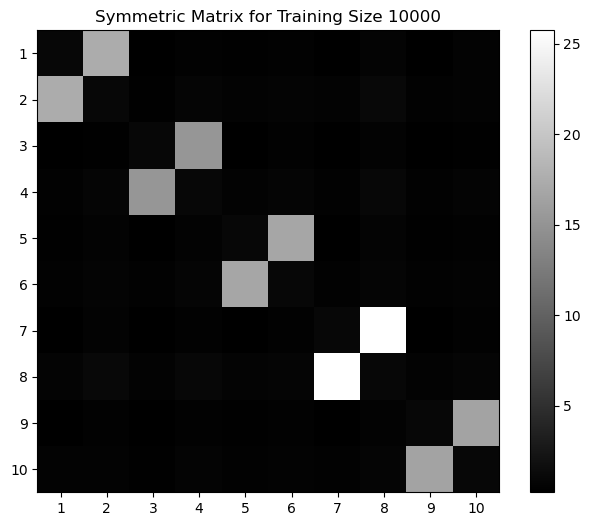

In [16]:

matrices = []
for training_size in training_sizes:
    # Load the models for the current training size
    print(training_size)
    loaded_models = torch.load(f'{save_directory}/tr{training_size}.pth')
    
    model_state_dicts = [loaded_models[f'model{i}_state_dict'] for i in range(1, num_features + 1)]

    models = []
    for i in range(num_features):
        model = MonotonicNN(num_features, hidden_layers, nb_steps, 'cpu')
        model.load_state_dict(model_state_dicts[i])
        models.append(model)

    precision_matrix = []

    for j in range(num_features):
        Sj = models[j]
        row = []
        Sj.eval()
        kth = j
        non_kth = [idx for idx in range(test_samples.shape[1]) if idx != kth]

        zk = test_samples.detach().requires_grad_(True)
        h = zk[:, non_kth]
        x = zk[:, [kth]]

        sk_zi = Sj(x, h)  
        for i in range(num_features):
            print(i, j)
            if i != j:
                first_derivative = torch.autograd.grad(sk_zi, zk, torch.ones_like(sk_zi), create_graph=True)[0]
                first_derivative = torch.log(torch.abs(first_derivative))
                second_derivative = torch.autograd.grad(first_derivative[:, [j]], zk, torch.ones_like(first_derivative[:, [j]]), create_graph=True)[0]
                third_derivative = torch.autograd.grad(second_derivative[:, [j]], zk, torch.ones_like(second_derivative[:, [j]]), create_graph=True)[0]

                second = torch.abs(third_derivative[:, [i]]).mean().item()
                first_half = -1 / 2 * (sk_zi ** 2)
                first_half_derivative = torch.autograd.grad(first_half, zk, torch.ones_like(first_half), create_graph=True)[0]
                second_half_deriative = torch.autograd.grad(first_half_derivative[:, [j]], zk, torch.ones_like(first_half_derivative[:, [j]]), create_graph=True)[0]

                first = torch.abs(second_half_deriative[:, [i]]).mean().item()
                row.append(first + second)
            else:
                row.append(1)
        precision_matrix.append(row)
        print(precision_matrix[-1])

    matrix = np.array(precision_matrix)
    transpose_matrix = matrix.T 
    symmetric_matrix = (transpose_matrix + matrix) / 2

    print(f"Symmetric matrix for training size {training_size}:")
    print(symmetric_matrix)
    matrices.append(symmetric_matrix)
    
    # Save the symmetric matrix
    np.save(f'{save_directory}/symmetric_matrix_{training_size}.npy', symmetric_matrix)
    
    # Plot the symmetric matrix
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
    plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
    plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Symmetric Matrix for Training Size {training_size}')
    plt.savefig(f'{save_directory}/symmetric_matrix_{training_size}.png')
    plt.show()


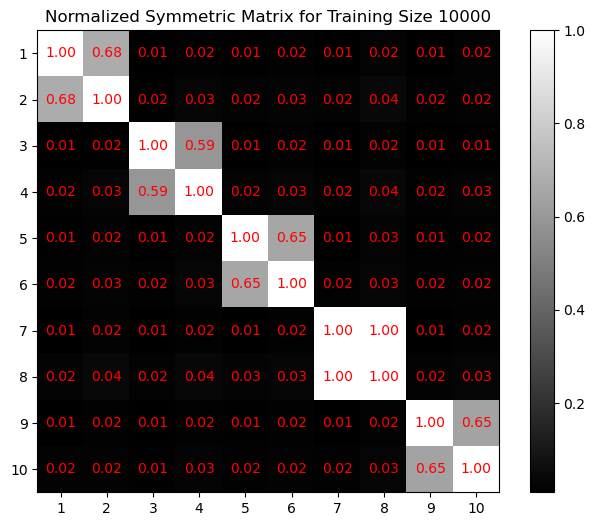

In [17]:

normalized_matrices = []

for training_size in training_sizes:
    matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')

    max_value = np.max(matrix)
    normalized_matrix = matrix / max_value
    np.fill_diagonal(normalized_matrix, 1)
    normalized_matrices.append((training_size, normalized_matrix))

for training_size, normalized_matrix in normalized_matrices:
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
    plt.yticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
    plt.imshow(normalized_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Normalized Symmetric Matrix for Training Size {training_size}')
    
    # Overlay the matrix values on the heatmap
    for i in range(len(normalized_matrix)):
        for j in range(len(normalized_matrix[i])):
            plt.text(j, i, f'{normalized_matrix[i, j]:.2f}', ha='center', va='center', color='red')

    plt.savefig(f'{save_directory}/normalized_symmetric_matrix_{training_size}.png')
    plt.show()


# Thresholding precision matrix

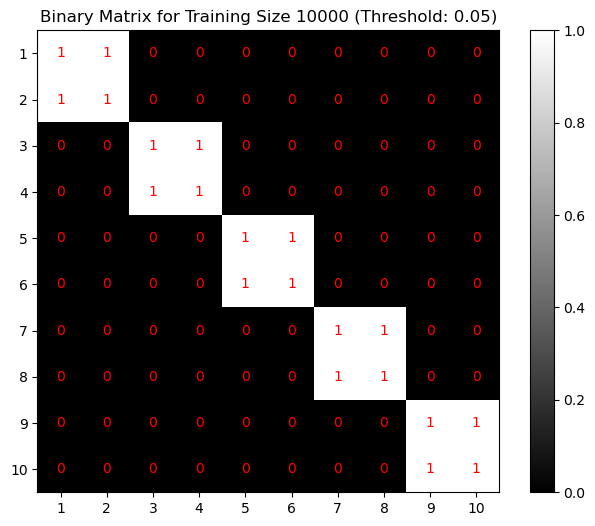

In [18]:
threshold = 0.05 
binary_matrices = []

for training_size in training_sizes:
    matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')

    max_value = np.max(matrix)
    normalized_matrix = matrix / max_value
    np.fill_diagonal(normalized_matrix, 1)
    # Apply the threshold to create a binary matrix
    binary_matrix = np.where(normalized_matrix < threshold, 0, 1)
    
    # Store the binary matrix
    binary_matrices.append((training_size, binary_matrix))

for training_size, binary_matrix in binary_matrices:
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(binary_matrix), 1), np.arange(1, len(binary_matrix) + 1))
    plt.yticks(np.arange(0, len(binary_matrix), 1), np.arange(1, len(binary_matrix) + 1))
    plt.imshow(binary_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Binary Matrix for Training Size {training_size} (Threshold: {threshold})')
    
    # Overlay the binary matrix values on the heatmap
    for i in range(len(binary_matrix)):
        for j in range(len(binary_matrix[i])):
            plt.text(j, i, f'{binary_matrix[i, j]}', ha='center', va='center', color='red')

    plt.savefig(f'{save_directory}/binary_matrix_{training_size}.png')
    plt.show()

100
[[1.         2.57240069 1.40540975 1.40535462 1.22318327 1.06272569
  0.73587224 1.75641888 0.79384363 1.1901308 ]
 [2.57240069 1.         1.17082745 1.53610235 1.25088128 1.19977683
  1.18322581 2.02004808 1.25799847 1.72619188]
 [1.40540975 1.17082745 1.         2.25438356 1.10565564 1.00559691
  1.22303978 1.16948235 1.22922212 1.58386618]
 [1.40535462 1.53610235 2.25438356 1.         1.26332247 1.12362832
  2.47606787 1.48084456 1.11105394 3.72309268]
 [1.22318327 1.25088128 1.10565564 1.26332247 1.         1.55346078
  0.66347572 1.39718729 1.39087921 1.14294618]
 [1.06272569 1.19977683 1.00559691 1.12362832 1.55346078 1.
  0.69443652 1.65472281 1.3889941  2.23123461]
 [0.73587224 1.18322581 1.22303978 2.47606787 0.66347572 0.69443652
  1.         1.62040216 0.84988043 1.04830754]
 [1.75641888 2.02004808 1.16948235 1.48084456 1.39718729 1.65472281
  1.62040216 1.         1.66266564 1.71082675]
 [0.79384363 1.25799847 1.22922212 1.11105394 1.39087921 1.3889941
  0.84988043 1.66

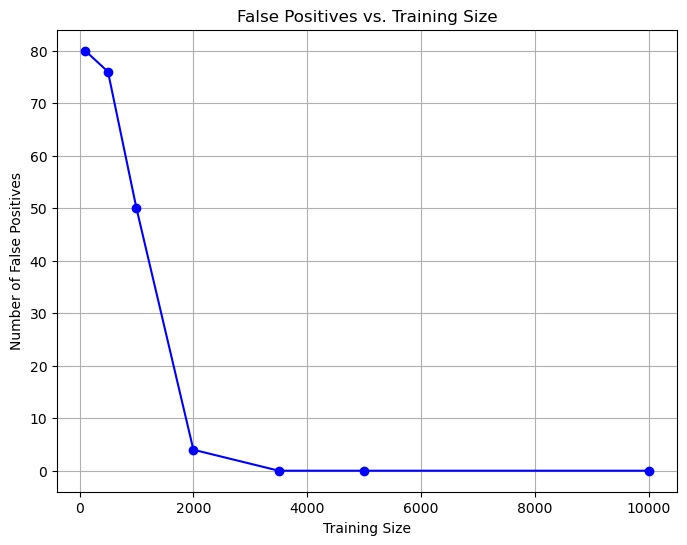

In [25]:
threshold = 0.1  
training_sizes  = [100, 500, 1000, 2000, 3500, 5000, 10000]

matrix_size = 10

ground_truth = np.eye(matrix_size)  
for i in range(0, matrix_size, 2):
    ground_truth[i, i+1] = 1
    ground_truth[i+1, i] = 1 
false_positives_list = []

for training_size in training_sizes:
    print(training_size)
    matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')
    print(matrix)
    # Normalize the matrix by its largest value
    max_value = np.max(matrix)
    normalized_matrix = matrix / max_value
    
    # Apply the threshold to create a binary matrix
    binary_matrix = np.where(normalized_matrix < threshold, 0, 1)
    
    # Compute the false positives
    false_positives = np.sum((ground_truth == 0) & (binary_matrix == 1))
    
    # Store the false positive count
    false_positives_list.append(false_positives)

# Plot false positives as a function of training sizes
plt.figure(figsize=(8, 6))
plt.plot(training_sizes, false_positives_list, marker='o', linestyle='-', color='blue')
plt.xlabel('Training Size')
plt.ylabel('Number of False Positives')
plt.title('False Positives vs. Training Size')
plt.grid(True)
plt.savefig(f'{save_directory}/false_positives_vs_training_size.png')
plt.show()

Training Size: 100, Threshold: 0.2
[[1.         2.57240069 1.40540975 1.40535462 1.22318327 1.06272569
  0.73587224 1.75641888 0.79384363 1.1901308 ]
 [2.57240069 1.         1.17082745 1.53610235 1.25088128 1.19977683
  1.18322581 2.02004808 1.25799847 1.72619188]
 [1.40540975 1.17082745 1.         2.25438356 1.10565564 1.00559691
  1.22303978 1.16948235 1.22922212 1.58386618]
 [1.40535462 1.53610235 2.25438356 1.         1.26332247 1.12362832
  2.47606787 1.48084456 1.11105394 3.72309268]
 [1.22318327 1.25088128 1.10565564 1.26332247 1.         1.55346078
  0.66347572 1.39718729 1.39087921 1.14294618]
 [1.06272569 1.19977683 1.00559691 1.12362832 1.55346078 1.
  0.69443652 1.65472281 1.3889941  2.23123461]
 [0.73587224 1.18322581 1.22303978 2.47606787 0.66347572 0.69443652
  1.         1.62040216 0.84988043 1.04830754]
 [1.75641888 2.02004808 1.16948235 1.48084456 1.39718729 1.65472281
  1.62040216 1.         1.66266564 1.71082675]
 [0.79384363 1.25799847 1.22922212 1.11105394 1.39087

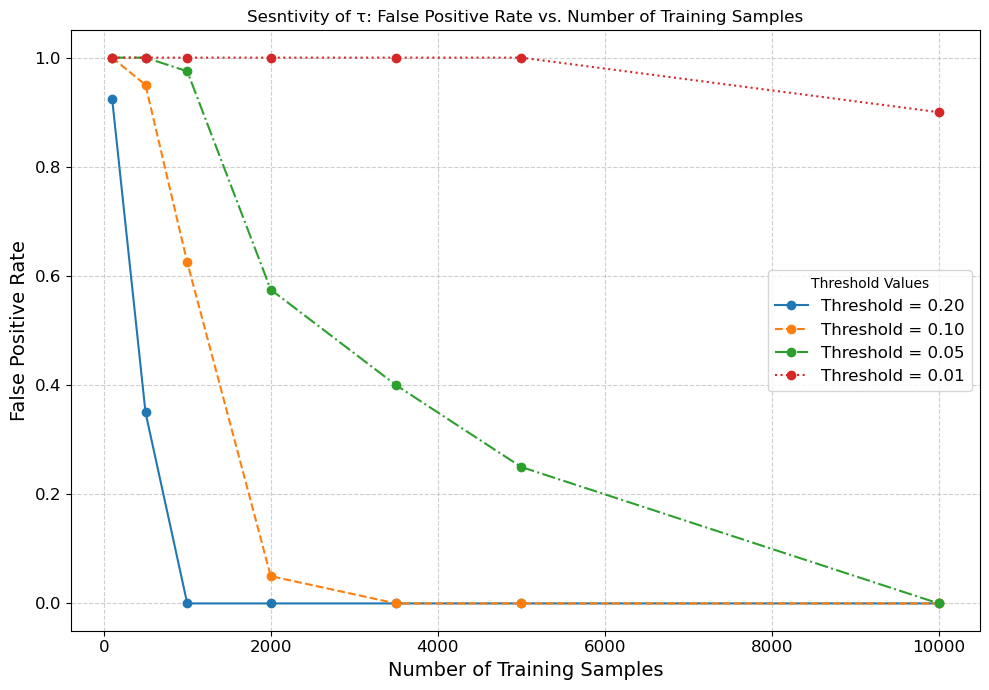

In [29]:

threshold_values = [0.2, 0.1, 0.05, 0.01]

training_sizes = [100, 500, 1000, 2000, 3500, 5000, 10000]

matrix_size = 10

ground_truth = np.eye(matrix_size)  # Start with the identity matrix (1s on the diagonal)

# Set the specific pairs to 1
for i in range(0, matrix_size, 2):
    ground_truth[i, i+1] = 1
    ground_truth[i+1, i] = 1  # Ensure symmetry

# Calculate the total number of negative entries in the ground truth matrix
total_negatives = np.sum(ground_truth == 0)

# Initialize a plot
plt.figure(figsize=(10, 7))

# Define line styles for each threshold
linestyles = ['-', '--', '-.', ':']

# Loop through each threshold value with corresponding line style
for i, threshold in enumerate(threshold_values):
    false_positive_rates_list = []

    # Loop through training sizes and compute false positive rates
    for training_size in training_sizes:
        print(f"Training Size: {training_size}, Threshold: {threshold}")

        matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')
        print(matrix)

        max_value = np.max(matrix)
        normalized_matrix = matrix / max_value

        binary_matrix = np.where(normalized_matrix < threshold, 0, 1)

        # Compute the false positives
        false_positives = np.sum((ground_truth == 0) & (binary_matrix == 1))

        # Calculate the false positive rate
        false_positive_rate = false_positives / total_negatives

        # Store the false positive rate
        false_positive_rates_list.append(false_positive_rate)

    # Plot the results for the current threshold with corresponding line style
    plt.plot(training_sizes, false_positive_rates_list, marker='o', linestyle=linestyles[i], label=f'Threshold = {threshold:.2f}')

plt.xlabel('Number of Training Samples', fontsize=14)
plt.ylabel('False Positive Rate', fontsize=14)
plt.title('Sesntivity of τ: False Positive Rate vs. Number of Training Samples')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Threshold Values', fontsize=12)
plt.tight_layout()

plt.savefig(f'{save_directory}/false_positive_rates_vs_training_size_thresholds.png', dpi=300)

plt.show()


Training Size: 100, Threshold: 0.2
[[1.         2.57240069 1.40540975 1.40535462 1.22318327 1.06272569
  0.73587224 1.75641888 0.79384363 1.1901308 ]
 [2.57240069 1.         1.17082745 1.53610235 1.25088128 1.19977683
  1.18322581 2.02004808 1.25799847 1.72619188]
 [1.40540975 1.17082745 1.         2.25438356 1.10565564 1.00559691
  1.22303978 1.16948235 1.22922212 1.58386618]
 [1.40535462 1.53610235 2.25438356 1.         1.26332247 1.12362832
  2.47606787 1.48084456 1.11105394 3.72309268]
 [1.22318327 1.25088128 1.10565564 1.26332247 1.         1.55346078
  0.66347572 1.39718729 1.39087921 1.14294618]
 [1.06272569 1.19977683 1.00559691 1.12362832 1.55346078 1.
  0.69443652 1.65472281 1.3889941  2.23123461]
 [0.73587224 1.18322581 1.22303978 2.47606787 0.66347572 0.69443652
  1.         1.62040216 0.84988043 1.04830754]
 [1.75641888 2.02004808 1.16948235 1.48084456 1.39718729 1.65472281
  1.62040216 1.         1.66266564 1.71082675]
 [0.79384363 1.25799847 1.22922212 1.11105394 1.39087

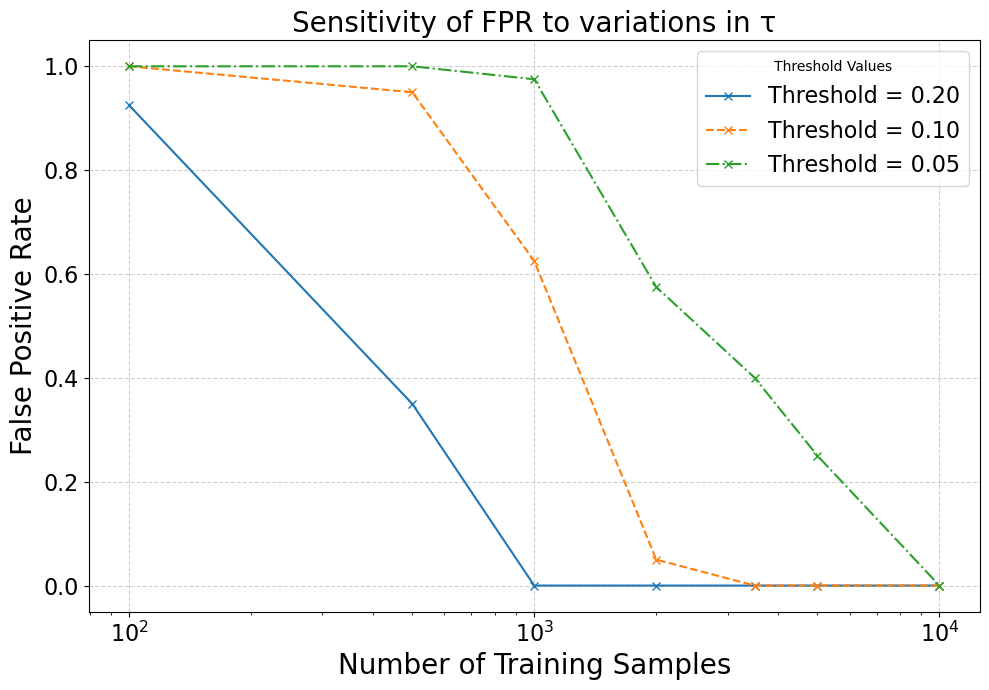

In [11]:

threshold_values = [0.2, 0.1, 0.05]

training_sizes = [100, 500, 1000, 2000, 3500, 5000, 10000]

matrix_size = 10

ground_truth = np.eye(matrix_size)  
for i in range(0, matrix_size, 2):
    ground_truth[i, i+1] = 1
    ground_truth[i+1, i] = 1  # Ensure symmetry

# Calculate the total number of negative entries in the ground truth matrix
total_negatives = np.sum(ground_truth == 0)

plt.figure(figsize=(10, 7))

linestyles = ['-', '--', '-.', ':']

for i, threshold in enumerate(threshold_values):
    false_positive_rates_list = []

    for training_size in training_sizes:
        print(f"Training Size: {training_size}, Threshold: {threshold}")

        matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')
        print(matrix)

        # Normalize the matrix by its largest value
        max_value = np.max(matrix)
        normalized_matrix = matrix / max_value

        # Apply the threshold to create a binary matrix
        binary_matrix = np.where(normalized_matrix < threshold, 0, 1)

        # Compute the false positives
        false_positives = np.sum((ground_truth == 0) & (binary_matrix == 1))

        # Calculate the false positive rate
        false_positive_rate = false_positives / total_negatives

        # Store the false positive rate
        false_positive_rates_list.append(false_positive_rate)

    plt.plot(training_sizes, false_positive_rates_list, marker='x', linestyle=linestyles[i], label=f'Threshold = {threshold:.2f}')

plt.xlabel('Number of Training Samples', fontsize=20)
plt.ylabel('False Positive Rate', fontsize=20)
plt.title('Sensitivity of FPR to variations in τ', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Threshold Values', fontsize=16)

plt.xscale('log')
plt.tight_layout()

# Save the plot
plt.savefig(f'{save_directory}/false_positive_rates_vs_training_size_thresholds.png', dpi=300)

# Show the plot
plt.show()


In [35]:
print(test_samples)

tensor([[ 0.8289,  1.3503,  0.3256,  ...,  0.1962, -0.2516, -0.4202],
        [-0.0587,  0.0026, -0.6916,  ..., -0.1389,  0.4334, -0.5928],
        [ 0.5460,  0.4231, -0.8863,  ...,  0.5025,  0.9002, -0.2475],
        ...,
        [ 0.3147,  0.5331,  1.0124,  ...,  0.5237,  0.6708,  0.3994],
        [-0.4309,  1.3082, -1.1901,  ...,  0.2698, -0.3909,  0.1544],
        [ 1.2388,  0.5343, -0.1850,  ...,  2.4728, -0.6737,  1.1008]])


# GLASSO

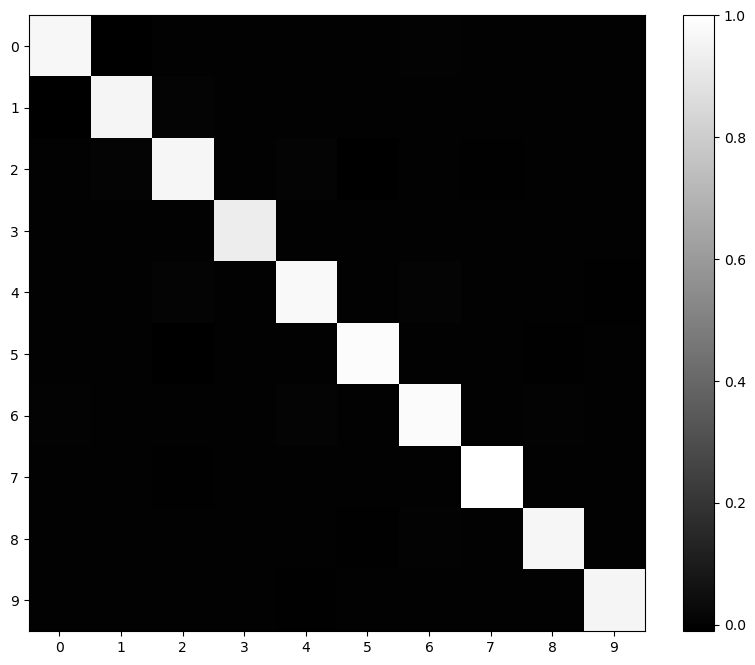

In [42]:
from sklearn.covariance import GraphicalLasso

model = GraphicalLasso() 
model.fit(test_samples)

precision_matrix = model.precision_

# Normalize the precision matrix
normalized_precision_matrix = precision_matrix / np.max(np.abs(precision_matrix))

# Plot the normalized precision matrix using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(normalized_precision_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(normalized_precision_matrix.shape[0]))
plt.yticks(np.arange(normalized_precision_matrix.shape[1]))
plt.grid(False)  
plt.show()